In [102]:
import sys
import os
import pandas as pd
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
from dotenv import load_dotenv
import plotly.express as px
from loguru import logger
from pydantic import BaseModel
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, PointStruct, VectorParams

sys.path.insert(0, '..')

from src.id_mapper import IDMapper
import src.viz

load_dotenv()

True

# Controller

In [2]:
class Args(BaseModel):
    testing: bool = False
    notebook_persist_dp: str = None
    random_seed: int = 41

    user_col: str = "user_id"
    item_col: str = "parent_asin"
    rating_col: str = "rating"
    timestamp_col: str = "timestamp"

    qdrant_url: str = None
    qdrant_collection_name: str = "item_desc_sbert"

    top_k: int = 10

    def init(self):
        if not (qdrant_host := os.getenv("QDRANT_HOST")):
            raise Exception(f"Environment variable QDRANT_HOST is not set.")

        qdrant_port = os.getenv("QDRANT_PORT")
        self.qdrant_url = f"{qdrant_host}:{qdrant_port}"

        return self

args = Args().init()

print(args.model_dump_json(indent=2))

{
  "testing": false,
  "notebook_persist_dp": null,
  "random_seed": 41,
  "user_col": "user_id",
  "item_col": "parent_asin",
  "rating_col": "rating",
  "timestamp_col": "timestamp",
  "qdrant_url": "localhost:6333",
  "qdrant_collection_name": "item_desc_sbert",
  "top_k": 10
}


# Load model

In [3]:
model = SentenceTransformer(
    "all-mpnet-base-v2",
    prompts={
        "classification": "Classify the following entertainment product description into different characteristics: ",
        "retrieval": "Retrieve semantically similar text: ",
        "clustering": "Identify the topic or theme based on the text: ",
    },
    default_prompt_name="clustering",
)

# The sentences to encode
sentences = [
    "Super Mario",
    "Pokemon",
    "Final Fantasy",
    "Diablo 3",
    "World of Warcraft",
    "Dota",
    "League of Legends"
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

Default prompt name is set to 'clustering'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


(7, 768)
tensor([[1.0000, 0.7523, 0.7229, 0.6226, 0.6043, 0.6279, 0.6148],
        [0.7523, 1.0000, 0.6922, 0.6775, 0.6057, 0.6701, 0.6665],
        [0.7229, 0.6922, 1.0000, 0.7260, 0.6649, 0.6406, 0.6467],
        [0.6226, 0.6775, 0.7260, 1.0000, 0.7900, 0.7606, 0.7804],
        [0.6043, 0.6057, 0.6649, 0.7900, 1.0000, 0.7972, 0.8204],
        [0.6279, 0.6701, 0.6406, 0.7606, 0.7972, 1.0000, 0.9076],
        [0.6148, 0.6665, 0.6467, 0.7804, 0.8204, 0.9076, 1.0000]])


# Load data

In [4]:
idm_fp = "../data/idm.json"
idm = IDMapper().load(idm_fp)

In [5]:
metadata_raw = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Video_Games", trust_remote_code=True
)
metadata_df = (
    metadata_raw["full"]
    .to_pandas()
    .loc[lambda df: df[args.item_col].isin(list(idm.item_to_index.keys()))]
    .assign(
        item_indice=lambda df: df[args.item_col].map(lambda s: idm.get_item_index(s))
    )
)
assert metadata_df[args.item_col].duplicated().sum() == 0
metadata_df

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,item_indice
2,Video Games,NBA 2K17 - Early Tip Off Edition - PlayStation 4,4.3,223,[The #1 rated NBA video game simulation series...,[Following the record-breaking launch of NBA 2...,58.0,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['NBA 2K17 - Kobe: Haters vs Players...,2K,"[Video Games, PlayStation 4, Games]","{""Release date"": ""September 16, 2016"", ""Best S...",B00Z9TLVK0,None,None,None,3057
15,Video Games,"Warhammer 40,000 Dawn of War Game of the Year ...",4.0,68,[Real-time strategy game based on the popular ...,"[From the Manufacturer, This Game of The Year ...",29.95,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",THQ,"[Video Games, PC, Games]","{""Release date"": ""September 20, 2005"", ""Best S...",B001EYUX4Y,None,None,None,1020
46,Video Games,Polk Audio Striker Zx Xbox One Gaming Headset ...,3.9,169,[Powered by 40 years of audio heritage and tun...,[Our ProFit Comfort system creates a lightweig...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Polk Audio,"[Video Games, Xbox One, Accessories, Headsets]","{""Release date"": ""October 5, 2014"", ""Best Sell...",B00OLOQGAY,None,None,None,2876
63,Video Games,The Legend of Heroes: Trails in the Sky - Sony...,4.4,91,[After a brief hiatus since its last release i...,"[Product Description, In the peaceful town of ...",185.0,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['The Legend of Heroes: Trails in th...,Xseed Games,"[Video Games, Legacy Systems, PlayStation Syst...","{""Release date"": ""March 29, 2011"", ""Best Selle...",B004BV5O0U,None,None,None,1663
65,Video Games,Harry Potter: Goblet of Fire - Sony PSP,3.6,38,[All the Magic of the Movie - Characters model...,"[From the Manufacturer, Be Harry Potter in a n...",19.43,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Electronic Arts,"[Purchase Circles, Geography, United States, M...","{""Release date"": ""September 8, 2006"", ""Best Se...",B001ELJEA6,None,None,None,785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118437,Video Games,Resident Evil 4,4.6,1133,[],[In Resident Evil 4 you'll know a new type of ...,44.98,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Capcom,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""June 19, 2007"", ""Best Seller...",B000P46NKC,None,None,None,551
118457,All Electronics,ivoler Carrying Storage Case for Nintendo Swit...,4.8,13702,[Deluxe Travel Carrying Case. Specially design...,[],26.39,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",ivoler,"[Video Games, Legacy Systems, Nintendo Systems...","{""Product Dimensions"": ""11.2 x 4 x 9 inches"", ...",B076GYVWRY,None,None,None,3799
118459,Video Games,EastVita New Charger Dock + 4 x Battery for Ni...,3.9,676,[Include: 1x Remote Controller Charger 4 x 280...,[Charger Dock + 4 x Battery for Wii Remote],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",EastVita,"[Video Games, Legacy Systems, Nintendo Systems...","{""Pricing"": ""The strikethrough price is the Li...",B004Y2VAVS,None,None,None,1795
118510,Video Games,Mario & Luigi: Partners In Time,4.6,607,"[Players use the top screen to study the land,...",[Mario and Luigi: Partners In Time an insane s...,99.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Nintendo,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""November 28, 2005"", ""Best Se...",B000B8J7K0,None,None,None,415


In [6]:
titles = metadata_df['title'].values
titles[:5]

array(['NBA 2K17 - Early Tip Off Edition - PlayStation 4',
       'Warhammer 40,000 Dawn of War Game of the Year - PC',
       'Polk Audio Striker Zx Xbox One Gaming Headset - Black',
       'The Legend of Heroes: Trails in the Sky - Sony PSP',
       'Harry Potter: Goblet of Fire - Sony PSP'], dtype=object)

In [104]:
%%time
title_embeddings = model.encode(titles, normalize_embeddings=True)
embedding_dim = title_embeddings.shape[1]

CPU times: user 11.7 s, sys: 4.2 s, total: 15.9 s
Wall time: 18.1 s


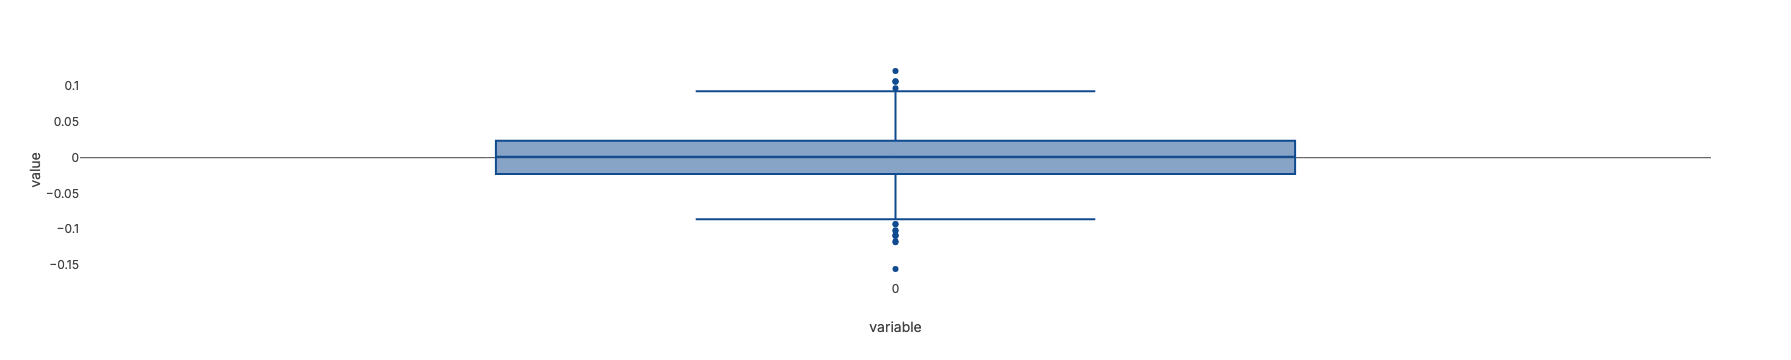

In [108]:
px.box(title_embeddings[0], width=500)

In [36]:
title_embeddings.shape

(4630, 768)

In [37]:
query = 'harry potter'
query_embedding = model.encode(query)
similarities = model.similarity(query_embedding, title_embeddings)

In [38]:
similarities

tensor([[0.5050, 0.5411, 0.4574,  ..., 0.4853, 0.5794, 0.5575]])

In [39]:
similarities = similarities.squeeze().detach().numpy()
nn_indices = np.argpartition(similarities, -10)[-10:]

In [40]:
pd.DataFrame({
    'target': [query] * 10,
    'score': similarities[nn_indices],
    'titles': titles[nn_indices]
})

,target,score,titles
0,harry potter,0.786267,LEGO Harry Potter: Years 5-7 - Playstation 3
1,harry potter,0.792318,Lego Harry Potter: Years 5-7 - PlayStation Vita
2,harry potter,0.852925,Harry Potter and the Deathly Hallows Part 1 - ...
3,harry potter,0.854980,Harry Potter: Prisoner of Azkaban - Xbox
4,harry potter,0.872698,Harry Potter: Goblet of Fire - Sony PSP
5,harry potter,0.877665,Harry Potter and the Sorcerer's Stone - PC
6,harry potter,0.878635,Harry Potter and the Order of the Phoenix - Ni...
7,harry potter,0.894921,Harry Potter and the Half Blood Prince - Xbox 360
8,harry potter,0.897954,Harry Potter and the Chamber of Secrets
9,harry potter,0.903514,"Harry Potter and the Deathly Hallows, Part 2"


In [41]:
titles[nn_indices]

array(['LEGO Harry Potter: Years 5-7 - Playstation 3',
       'Lego Harry Potter: Years 5-7 - PlayStation Vita',
       'Harry Potter and the Deathly Hallows Part 1 - Playstation 3',
       'Harry Potter: Prisoner of Azkaban - Xbox',
       'Harry Potter: Goblet of Fire - Sony PSP',
       "Harry Potter and the Sorcerer's Stone - PC",
       'Harry Potter and the Order of the Phoenix - Nintendo Wii',
       'Harry Potter and the Half Blood Prince - Xbox 360',
       'Harry Potter and the Chamber of Secrets',
       'Harry Potter and the Deathly Hallows, Part 2'], dtype=object)

# Create text features

In [69]:
text_features_df = (
    metadata_df.assign(
        text_list=lambda df: df.apply(lambda row: [row['title'], *row['features']], axis=1)
    )
    [[args.item_col, 'text_list']]
    .explode('text_list')
)

In [70]:
%%time
sbert_features = model.encode(text_features_df['text_list'].values)

CPU times: user 2min 30s, sys: 19.5 s, total: 2min 49s
Wall time: 1min 12s


In [71]:
text_features_df = (
    text_features_df.reset_index(drop=True)
    .assign(
        sbert_features=pd.Series(sbert_features.tolist())
    )
)

In [85]:
def mean_pooling(series):
    return np.vstack(series).mean(axis=0)

text_features_agg_df = (
    text_features_df
    .groupby([args.item_col])['sbert_features'].apply(mean_pooling)
    .to_frame('text_feature_embedding').reset_index()
    .pipe(
        lambda df: pd.merge(df, metadata_df, how='left', on=args.item_col)
    )
)
text_features_agg_df

,parent_asin,text_feature_embedding,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,bought_together,subtitle,author,item_indice
0,0375869026,"[0.028166535144139613, 0.01898332020001752, -0...",Books,Wonder,4.7,83449,"[#1, NEW YORK TIMES, BESTSELLER •, Millions of...","[Amazon.com Review, Amazon Best Books of the M...",9.4,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': ['Wonder', 'Wonder: Book Trailer', '...",R. J. Palacio (Author),"[Video Games, PC, Games]","{""Publisher"": ""Knopf Books for Young Readers; ...",None,"Hardcover – February 14, 2012",{'avatar': 'https://m.media-amazon.com/images/...,0
1,9625990674,"[0.04856508985782663, -0.04497016749034325, -0...",Video Games,Silicone Protective Case for Controller (Black),3.8,159,[Anti Skid Silicone Skin Protector for Xbox 36...,[Silicone Protective Case for Controller (Black)],None,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Mycarryingcase,"[Video Games, Legacy Systems, Xbox Systems, Xb...","{""Pricing"": ""The strikethrough price is the Li...",None,None,None,1
2,9629971372,"[0.0478080241009593, -0.04462047480046749, -0....",Computers,Dotop Sony Playstation 2 PS2 64MB Memory Card,4.4,630,[brand new],[This is Memory Card 128MB for PlayStation 2 P...,None,"{'hi_res': [None, 'https://m.media-amazon.com/...",{'title': ['A memory card that surpasses the o...,Dotop,"[Video Games, Legacy Systems, PlayStation Syst...","{""Product Dimensions"": ""4.9 x 2.7 x 0.1 inches...",None,None,None,2
3,9861019731,"[0.053799957684532274, -0.012497934745624661, ...",Video Games,Memory Card for Wii Console 64 MB (1019 Blocks),4.1,487,"[Brand New & Factory Sealed, Gamecube & Wii Co...",[1019 Block Nintendo Gamecube and Wii Compatab...,4.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",GEN,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""March 5, 2013"", ""Best Seller...",None,None,None,3
4,9882155456,"[0.05832385038957, -0.0035558436842014394, -0....",Video Games,2 Pack - Gator Crunch Wii Gamecube 6FT Extensi...,4.1,117,"[2 PACK - GameCube Extension Cable / Cord Set,...",[],None,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Gator Crunch,"[Video Games, Legacy Systems, Nintendo Systems...","{""Pricing"": ""The strikethrough price is the Li...",None,None,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,B0CB6B58Q9,"[0.058850289011994995, -0.014266196948786577, ...",Video Games,Pikmin 3 Deluxe - Nintendo Switch [Digital Code],4.7,433,[Grow a squad of adorable Pikmin and save your...,"[Grow a squad of adorable, plantlike Pikmin to...",59.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Nintendo,"[Video Games, Nintendo Switch, Games]","{""Release date"": ""October 29, 2020"", ""Best Sel...",None,None,None,4625
4626,B0CB8LZT7K,"[0.05815527898569902, -0.043956747744232416, -...",Video Games,Daydayup Switch Carrying Case Compatible with ...,4.8,30290,[High Quality Case - High Quality Durable hard...,[],21.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",daydayup,"[Video Games, Legacy Systems, Nintendo Systems...","{""Product Dimensions"": ""10.2 x 2 x 4.9 inches""...",None,None,None,4626
4627,B0CB9V2FYF,"[0.046922826363394655, -0.005057462956756353, ...",Video Games,Nintendo Licensed Classic Edition NES & SNES C...,4.8,2316,[Securely holds NES Classic or SNES Classic Ed...,[A beautiful case designed to store and protec...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Does not fit anywhere close', 'Jus...",RDS Industries,"[Video Games, Legacy Systems, Nintendo Systems]","{""Package Dimensions"": ""11.77 x 11.26 x 3.54 i...",None,None,None,4627
4628,B0CBRT4BWW,"[0.05536631203722209, -0.05965651975323757, -0...",All

# Push to Qdrant

In [86]:
ann_index = QdrantClient(url=args.qdrant_url)

In [87]:
collection_exists = ann_index.collection_exists(args.qdrant_collection_name)
if collection_exists:
    logger.info(f"Deleting existing Qdrant collection {args.qdrant_collection_name}...")
    ann_index.delete_collection(args.qdrant_collection_name)

create_collection_result = ann_index.create_collection(
    collection_name=args.qdrant_collection_name,
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

assert create_collection_result == True

2024-10-27 16:38:44.813 | INFO     | __main__:<module>:3 - Deleting existing Qdrant collection item_desc_sbert...


In [89]:
points = []

for i, row in text_features_agg_df.reset_index(drop=True).iterrows():
    item_indice = int(row['item_indice'])
    vector = row['text_feature_embedding'].tolist()
    payload = {
        args.item_col: row[args.item_col],
        'title': row['title'],
    }
    point = PointStruct(id=item_indice, vector=vector, payload=payload)
    points.append(point)

In [90]:
batch_size = 32

for i in tqdm(range(0, len(points), batch_size)):
    batch_points = points[i:i+batch_size]
    upsert_result = ann_index.upsert(
        collection_name=args.qdrant_collection_name,
        points=batch_points,
    )
    assert str(upsert_result.status) == "completed"
upsert_result

  0%|          | 0/145 [00:00<?, ?it/s]

UpdateResult(operation_id=144, status=<UpdateStatus.COMPLETED: 'completed'>)

In [98]:
query_vector = title_embeddings[7]

hits = ann_index.search(
    collection_name=args.qdrant_collection_name,
    query_vector=query_vector,
    limit=args.top_k,
)
hits

[ScoredPoint(id=3615, version=112, score=0.8026285, payload={'parent_asin': 'B06ZYTHKR7', 'title': 'Call of Duty: WWII - PlayStation 4 Standard Edition'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1003, version=31, score=0.8022863, payload={'parent_asin': 'B001EYUWL8', 'title': "Tom Clancy's EndWar - Nintendo DS"}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1012, version=31, score=0.79514515, payload={'parent_asin': 'B001EYUWXQ', 'title': "Tom Clancy's Ghost Recon Advanced Warfighter 2 [Download]"}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=283, version=8, score=0.79381406, payload={'parent_asin': 'B00009WAVB', 'title': 'Medal of Honor Rising Sun - PlayStation 2'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=3921, version=122, score=0.7910949, payload={'parent_asin': 'B07D8FFMKK', 'title': 'Battlefield V (PS4)'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=926, version=28, score=0.7